In [1]:
include("util_integrate.jl")

# Intégration avec la méthode des rectangles

Essayons d'approcher le calcul d'une intégrale avec la méthode des rectangles :

\begin{align}
I_{a,b}^n(f) = \frac{b-a}{n} \sum_{i=1}^n f(x_i)
\end{align}

où $x_i = a + \frac{b-a}{n} (i+\frac{1}{2})$.

Les mathématiques nous disent que :

\begin{align*}
I_{a,b}^n(f) - \int_a^b f(x) dx = \mathcal{O}\left(\frac{1}{n}\right).
\end{align*}

Regardons ce qui se passe en pratique...

In [2]:
function integrate(fun, a, b, n, T=Float64)
    a = T(a); b = T(b)
    
    dx  = (b-a)/n
    x   = a + dx/2
    acc = T(0)
    while x<b
        acc += fun(x)*dx
        x += dx
    end
    acc
end

integrate (generic function with 2 methods)

## Un cas test simple

\begin{align}
\int_0^1 x^3 dx = \frac{1}{4}
\end{align}

In [3]:
cube(x) = x^3
integrate(cube, 0, 1, 10000)

0.2499999987499343

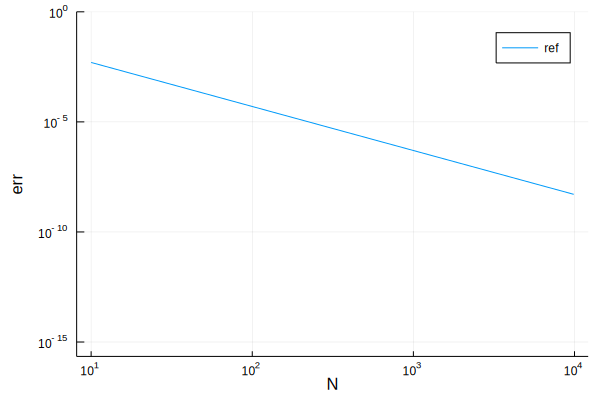

In [4]:
test(Float64) do n, T
    fun = cube
    ref = 1/4
    
    v = integrate(fun, 0, 1, n, T)
    ϵ = abs(v - ref)/abs(ref)
    
    (ref=ϵ,)
end

## Peut-on utiliser des flottants 32 bits ?

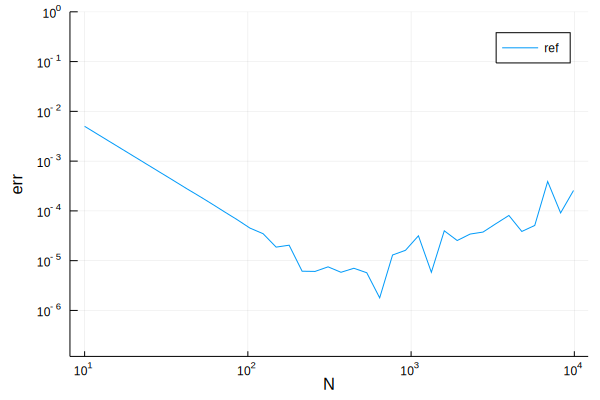

In [5]:
test(Float32) do n, T
    fun = cube
    ref = 1/4
    
    v = integrate(fun, 0, 1, n, T)
    ϵ = abs(v - ref)/abs(ref)
    
    (ref=ϵ,)
end

## Evaluation des erreurs d'arrondi

Une première manière d'attribuer les "mauvais comportements" à l'arithmétique flottante consiste à utiliser une arithmétique plus précise comme référence. Par exemple: l'arithmétique rationnelle.

Même si Julia n'avait pas de type `Rational`, il serait assez simple d'en faire un nous-mêmes...

In [6]:
integrate(cube, 0, 1, 100, MyRational{BigInt})

19999/80000

Qui est à peu près aussi performant que celui de la bibliothèque standard !

In [7]:
@btime integrate(cube, 0, 1, 100, MyRational{BigInt})
@btime integrate(cube, 0, 1, 100, Rational{BigInt})

  757.937 μs (19527 allocations: 369.63 KiB)
  602.410 μs (17334 allocations: 325.64 KiB)


19999//80000

In [8]:
test(Float32) do n, T
    fun = cube
    ref = 1/4
    
    v = integrate(fun, 0, 1, n, T)
    ϵ = abs(v - ref)/abs(ref)
        
    v_rat = integrate(fun, 0, 1, n, MyRational{BigInt}) |> to_float
    ϵ_rat = abs(v - v_rat)/abs(v_rat)
    
    (ref=ϵ, rat=ϵ_rat)
end;

Conclusion : les "mauvais comportements" peuvent être attribués à l'arithmétique flottante.

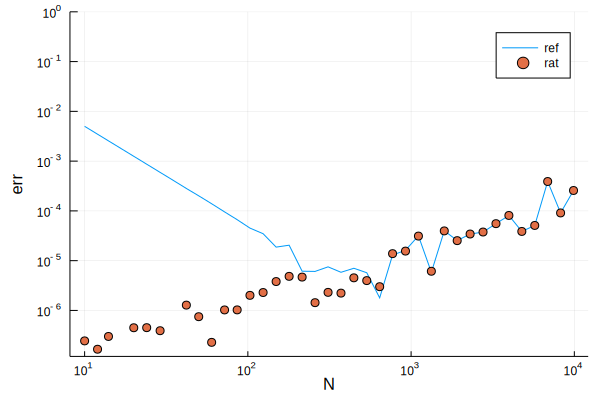

In [9]:
ans

Quid de calculs plus compliqués ?
\begin{align}
\int_{0,1}\sqrt{x}\;dx
\end{align}

<br/>

L'arithmétique rationnelle a ses propres limites. Place à l'arithmétique stochastique !

## Arithmétique stochastique

In [10]:
using StochasticArithmetic

integrate(cube, 0, 1, 1000, SFloat32)

SF32(0.25000405)

In [11]:
for _ in 1:10
    integrate(cube, 0, 1, 1000, SFloat32) |> println
end

SF32(0.25000393)
SF32(0.2500043)
SF32(0.2500035)
SF32(0.25000465)
SF32(0.25000367)
SF32(0.25000367)
SF32(0.25000423)
SF32(0.25000373)
SF32(0.25000274)
SF32(0.25000462)


In [12]:
@reliable_digits integrate(cube, 0, 1, 1000, SFloat32)

(0.25000402f0, 5.822241f0)

In [13]:
using StochasticArithmetic: SFloat

test(Float32) do n, T
    fun = cube
    ref = 1/4
    
    v = integrate(fun, 0, 1, n, T)
    ϵ = abs(v - ref)/abs(ref)
        
    v_rat = integrate(fun, 0, 1, n, MyRational{BigInt}) |> to_float
    ϵ_rat = abs(v-v_rat)/abs(v_rat)

    v_sto,_ = @reliable_digits integrate(fun, 0, 1, n, SFloat{T})
    ϵ_sto = abs(v_sto-v)/abs(v)
    
    (ref=ϵ,
     rat=ϵ_rat,
     sto=ϵ_sto)
end;

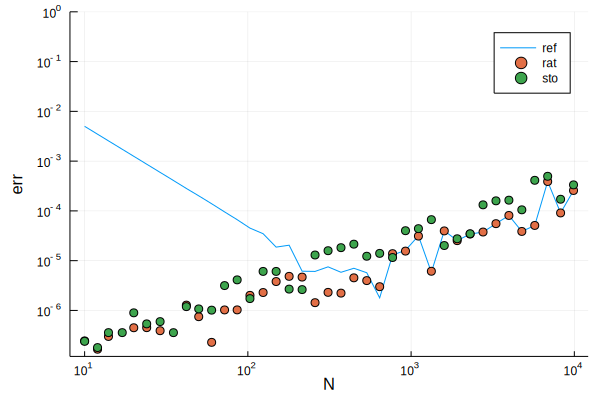

In [14]:
ans

## Etude d'une implémentation corrigée

In [15]:
function integrate(fun, a, b, n, T=Float64)
    a = T(a); b = T(b)
    
    dx  = (b-a)/n
    acc = T(0)
    for i in 1:n
        x = a + i*dx + dx/2
        acc += fun(x)*dx
    end
    acc
end

integrate (generic function with 2 methods)

In [16]:
test(Float32) do n, T
    fun = cube
    ref = 1/4
    
    v = integrate(fun, 0, 1, n, T)
    ϵ = abs(v - ref)/abs(ref)
        
    v_rat = integrate(fun, 0, 1, n, MyRational{BigInt}) |> to_float
    ϵ_rat = abs(v - v_rat)/abs(v_rat)

    v_sto,_ = @reliable_digits integrate(fun, 0, 1, n, SFloat{T})
    ϵ_sto = abs(v_sto-v)/abs(v)
    
    (ref=ϵ,
     rat=ϵ_rat,
     sto=ϵ_sto)
end;

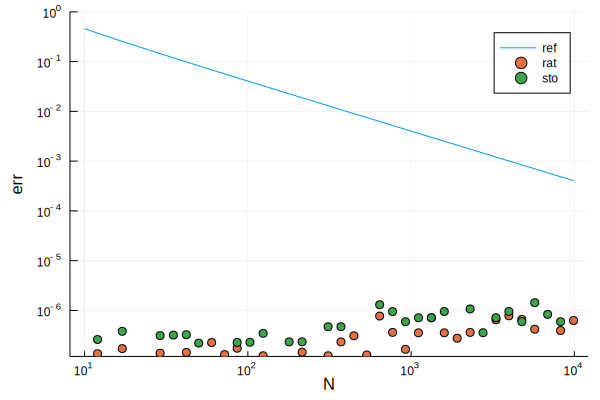

In [17]:
ans